In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import torch
import pyNNGLS
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img 
import geopandas as gpd
from shapely.geometry import Point
from scipy import spatial, interpolate
import warnings
warnings.filterwarnings("ignore")

In [24]:
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_nation_20m.zip"
us = gpd.read_file(url).explode()
us = us.loc[us.geometry.apply(lambda x: x.exterior.bounds[2])<-60]

In [25]:
df_covariates = pd.read_csv('./data/covariate0605.csv')
df_pm25 = pd.read_csv('./data/pm25_0605.csv')
df_pm25 = df_pm25.loc[df_pm25.Latitude < 50]

x_min,y_min,x_max,y_max = np.array([np.min(df_covariates['long']), np.min(df_covariates['lat']),
    np.max(df_covariates['long']), np.max(df_covariates['lat'])])
arr1 = np.mgrid[x_min:x_max:101j, y_min:y_max:101j]

# extract the x and y coordinates as flat arrays
arr1x = np.ravel(arr1[0])
arr1y = np.ravel(arr1[1])
# using the X and Y columns, build a dataframe, then the geodataframe
df = pd.DataFrame({'X':arr1x, 'Y':arr1y})
df['coords'] = list(zip(df['X'], df['Y']))
df['coords'] = df['coords'].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.X, y=df.Y),crs = us.crs)
inUS = gdf['geometry'].apply(lambda s: s.within(us.geometry.unary_union))

In [28]:
lonlat_pm25=df_pm25.values[:,[1,2]]
near = df_covariates.values[:,[1,2]]
tree = spatial.KDTree(list(zip(near[:,0].ravel(), near[:,1].ravel())))
idx = tree.query(lonlat_pm25)[1]
df_pm25_mean = df_pm25.assign(neighbor = idx).groupby('neighbor')['PM25'].mean()
idx_new = df_pm25_mean.index.values
pm25 = df_pm25_mean.values
z = pm25[:,None]

lon = df_covariates.values[:,1]
lat = df_covariates.values[:,2]

f = interpolate.Rbf(lon[idx_new], lat[idx_new], z, function = 'inverse')
x_test = gdf.loc[inUS,:].X
y_test = gdf.loc[inUS,:].Y
z_test = f(x_test, y_test)

<Figure size 640x480 with 0 Axes>

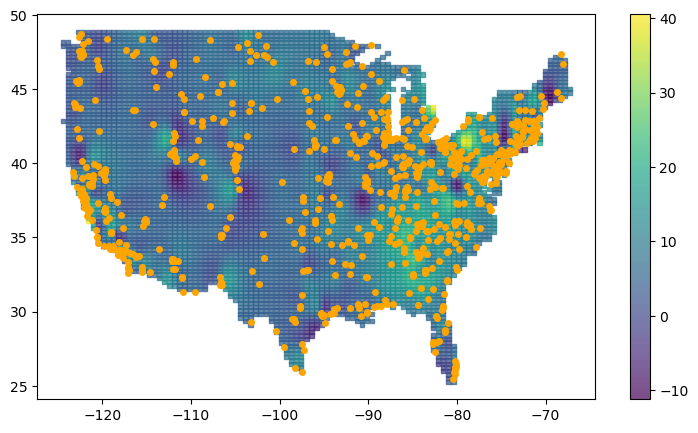

In [29]:
f = interpolate.Rbf(lon[idx_new], lat[idx_new], z, function = 'inverse')
x_test = gdf.loc[inUS,:].X
y_test = gdf.loc[inUS,:].Y
z_test = f(x_test, y_test)
plt.clf()
fig, ax = plt.subplots(figsize=(9, 5))
c = ax.scatter(x = x_test, y = y_test, s = 10, c = z_test, marker = 's', alpha = 0.7)
ax.plot(np.array(df_pm25['Longitude']), np.array(df_pm25['Latitude']), 'o', c = 'orange', markersize = 4)
ax.set_title('')
fig.colorbar(c, ax=ax)
plt.show()

In [31]:
data_PM25 = pd.read_csv("./data/Normalized_PM2.5_20190605.csv")
data_PM25

,Unnamed: 0,precipitation,temperature,air pressure,relative humidity,U-wind,V-wind,PM 2.5,longitude,latitude
0,0,0.008044,0.362296,0.887664,0.774197,0.868530,0.781498,5.020834,0.980311,0.906268
1,1,0.005516,0.355305,0.882153,0.751742,0.864206,0.770715,3.837500,0.983093,0.889762
2,2,0.000000,0.335323,0.928359,0.714189,0.697080,0.813224,2.041666,0.974238,0.814722
3,3,0.000000,0.338579,0.954218,0.690767,0.625266,0.868161,3.669444,0.976951,0.798275
4,4,0.002528,0.293827,0.893599,0.685830,0.688808,0.842395,1.020833,0.945193,0.800337
...,...,...,...,...,...,...,...,...,...,...
600,600,0.393932,0.901079,0.972022,0.910279,0.642436,0.469410,5.168750,0.469337,0.101640
601,601,0.000689,0.810329,0.897414,0.539392,0.553265,0.464926,6.041666,0.436702,0.098054
602,602,0.294415,0.882501,0.972022,0.822590,0.642248,0.469353,8.704166,0.468665,0.090378
603,603,0.011492,0.811830,0.965240,0.719028,0.676463,0.512429,8.725000,0.460179,0.035680


In [32]:
X = torch.from_numpy(data_PM25[['precipitation', 'temperature', 'air pressure', 'relative humidity', 'U-wind', 'V-wind']].to_numpy()).float()
Y = torch.from_numpy(data_PM25[['PM 2.5']].to_numpy().reshape(-1)).float()
coord = torch.from_numpy(data_PM25[['longitude', 'latitude']].to_numpy()).float()

p = X.shape[1]

n = X.shape[0]
nn = 20
batch_size = 50

data = pyNNGLS.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = pyNNGLS.split_data(X, Y, coord, neighbor_size = 20, 
                                                   test_proportion = 0.2)

In [33]:
start_time = time.time()
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
nn_model = pyNNGLS.nn_train(mlp_nn, lr =  0.01, min_delta = 0.001)
training_log = nn_model.train(data_train, data_val, data_test)

Epoch 00050: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00060: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00070: reducing learning rate of group 0 to 1.2500e-03.
INFO: Early stopping
End at epoch73


In [35]:
theta0 = pyNNGLS.theta_update(torch.tensor([1, 1.5, 0.01]), mlp_nn(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size = 20)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
)
model = pyNNGLS.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
nngls_model = pyNNGLS.nngls_train(model, lr =  0.01, min_delta = 0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init = 20, Update_step = 10)
end_time = time.time()

Theta updated from
[1.   1.5  0.01]
Epoch 00015: reducing learning rate of group 0 to 5.0000e-03.
Theta updated from
[9.06395941 7.97919851 0.25205426]
to
[11.92068303  5.98421723  0.17382521]
Epoch 00027: reducing learning rate of group 0 to 2.5000e-03.
Theta updated from
[11.92068303  5.98421723  0.17382521]
to
[9.69696992 7.20076319 0.21574464]
INFO: Early stopping
End at epoch30


In [36]:
print(f"\rRunning time: {end_time - start_time} seconds")

Running time: 26.127090215682983 seconds


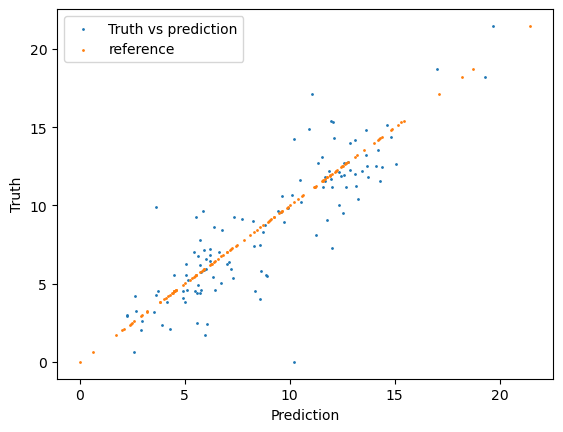

In [37]:
test_predict = model.predict(data_train, data_test)
plt.clf()
plt.scatter(test_predict.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'Truth vs prediction')
plt.scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'reference')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()
plt.show()